Este documento esta basado en el paper "Frequency Shift Chirp Modulation: The LoRa Modulation", escrito por Lorenzo Evangelista,  junto al video "Cómo funciona realmente la modulación LoRa" de  "Visual Electric" basado en dicho paper.



#Modulación LoRa

En este informe se detallará la Modulación LoRa, y se analizarán sus ventajas y desventajas.

Modulación LoRa, en inglés Long Range Modulation, es una modulación de espectro expandido muy útil en usos donde se requiera bajo consumo energético y un alto rango.

Este tipo de modulación se caracteriza por usar de base una forma de onda 'chirp'. Es decir, su frecuencia varia linealmente con el tiempo.

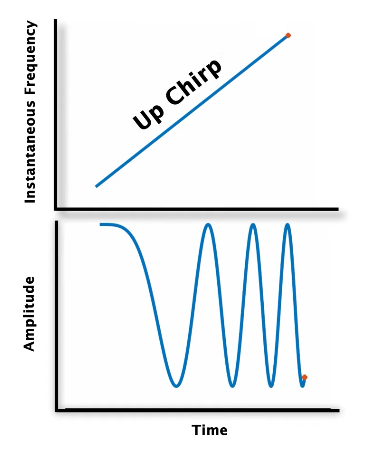


El principio de funcionamiento de Modulacion LoRa, se basa en la variación de la frecuencia perteneciente a la onda en el tiempo como se observa en la imágen anterior.
El set de simbolos pueden ser generados por medio de la siguiente formula:

$$c(nT_s+kT) = \frac{1}{\sqrt{2^{SF}}} e^{j2\pi \left[ (s(nT_s)+k)_{mod}2^{SF}\right]kT\frac{B}{2^{SF}}}$$

Vemos que la frecuencia de la onda modulada incrementa linealmente según el valor de k.

Observamos los siguientes parametros:

**SF (Spreading Factor):** Cantidad de simbolos que pueden transmitirse. Normalmente toma valores entre 7 y 12.

**Ts:** Tiempo que tarda en transmitirse un simbolo.

**T:** Duración de una muestra.

**s:** Simbolo a enviar. Toma valores entre 0 y $2^{SF}-1$.

A continuación mostraremos la forma de onda para enviar un simbolo arbitrario. El codigo utilizado fue creado basandose en un video informativo sobre el tema, y utilizando el paper.

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

In [ ]:
def lora_generator(SF, B, s, paso):
  Ts = 2**SF
  T = 1/B

  num_muestras = int(2**SF*1/paso)

  lora_tiempo = []
  lora_frecuencia = []

  k = s
  f_max = (2**SF-1)*B/(Ts)

  for n in range(num_muestras):
    f = k*B/(Ts)
    t = k * T

    if(f>f_max):
      k = k-Ts
      f = k*B/Ts
    muestra = (1/(np.sqrt(Ts)))*np.exp(1j*2*np.pi*f*t*1/2)
    lora_tiempo.append(muestra)
    lora_frecuencia.append(f)
    k = k+paso

  return lora_tiempo, lora_frecuencia, num_muestras

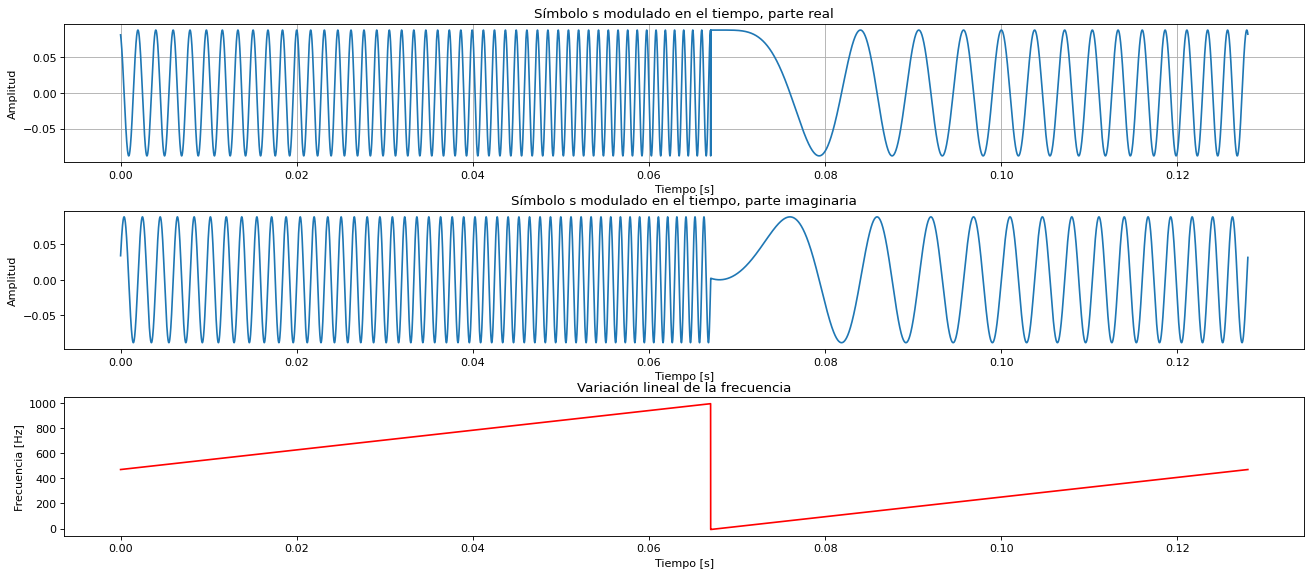

In [ ]:
SF = 7
B = 1000
s = 60
paso = 0.01
lora_tiempo, lora_frecuencia, num_muestras = lora_generator(SF, B, s, paso)

#t es un arreglo que va desde 0 hasta num_muestras*delt con un paso de delt
t = np.arange(0, num_muestras/B*paso, paso/B)
plt.figure(figsize=(20,8), dpi= 80, facecolor='w', edgecolor='k')
plt.subplot(3,1,1)
plt.plot(t,np.real(lora_tiempo))
plt.title('Símbolo s modulado en el tiempo, parte real')
plt.xlabel('Tiempo [s]')
plt.ylabel('Amplitud')
plt.grid()
plt.subplot(3,1,2)
plt.plot(t,np.imag(lora_tiempo))
plt.title('Símbolo s modulado en el tiempo, parte imaginaria')
plt.xlabel('Tiempo [s]')
plt.ylabel('Amplitud')
plt.subplot(3,1,3)
plt.plot(t,lora_frecuencia, color = 'red')
plt.title('Variación lineal de la frecuencia')
plt.xlabel('Tiempo [s]')
plt.ylabel('Frecuencia [Hz]')

plt.subplots_adjust(left=0.125,
                    bottom=0.1, 
                    right=0.9, 
                    top=0.9, 
                    wspace=0.2, 
                    hspace=0.35)

A partir de los gráficos anteriores se puede observar que cuándo la frecuencia instantánea llega a su valor máximo **f_max**, decae a la frecuencia más baja provocando una discontinuidad.
Además se puede ver que la frecuencia inicial es igual a la frecuencia final.

# Receptor

Suponiendo un SF de 7, contamos con 128 simbolos diferentes a los que se debe comparar utilizando una correlación, para seleccionar cual fue el simbolo que se recibio. Esto se hace haciendo la proyección de la señal que fue recibida, con cada uno de los simbolos base, y seleccionando el simbolo que tenga el valor mayor de correlación.

Esto es muy ineficiente, ya que se deben realizar muchas operaciones, pero esto puede ser solucionado utlizando un 'truco matematico'.

Función de correlación:

$\sum_{k=0}^{2^{SF}-1} r(nT_{s} + kT) \cdot  c^{\ast}(nT_{s} + kT)$

Observamos la función de los simbolos base, la cual se puede conjugar facilmente haciendo negativo el exponente de la función $e$:

$c^{\ast}(nTs + kT) = \frac{1}{\sqrt{2^{SF}}}e^{-j2\pi(s(nT_{s})+k \ mod \ 2^{SF})\frac{k}{2^{SF}}}$

Luego, sumamos y restamos $k$ en el exponente:

$c^{\ast}(nTs + kT) = \frac{1}{\sqrt{2^{SF}}}e^{-j2\pi(s(nT_{s})+k \ mod \ 2^{SF}+k-k)\frac{k}{2^{SF}}}$

Esto nos permite separar la función en dos exponenciales de la siguiente forma:
$c^{\ast}(nTs + kT)=\frac{1}{\sqrt{2^{SF}}}(e^{-j2\pi \frac{k^2}{\sqrt{2^{SF}}}})\ e^{-j2\pi(s(nT_{s})+k \ mod \ 2^{SF}-k)\frac{k}{2^{SF}}}$

Si analizamos esta expresión, vemos que la primer exponencial es una down-chirp base, con $s=0$.
La segunda exponencial, es una onda pura con frecuencia $s$.


Al multiplicar la señal recibida por la down-chirp base, tenemos el procedimiento conocido como Dechirping. Aplicando este procedimiento, obtendremos una onda pura de frecuencia $s$, y para hallar el simbolo que corresponde al que fue enviado, le aplicamos la transformada rapida de Fourier, para hallar su componente de frecuencia.

Con esto quitamos el requisito de hacer las correlaciones ineficientes con cada chirp, y obtenemos el set de números, correspondiente con la similaridad a cada simbolo base.

In [ ]:
#def base_down_chirp(SF, B, paso):
#  #La base down chirp
#  base_down_chirp_t = []
#  base_down_chirp_f = []
#  k = 0
#
#  for n in range(int(2**SF*1/paso)):#Produzco la señal lora con un s = 0
#    f = k*B/(2**SF)
#    t = k*1/B
#    muestra = (1/(np.sqrt(2**SF)))*np.exp(-1j*2*np.pi*f*t*1/2)
#    base_down_chirp_t.insert(0,muestra)#Al poner insert(0,--) estoy insertando en la primera posicion del arreglo, desplazando los valores ya contenidos a la siguiente posicion de esta forma invierto los elementos
#    base_down_chirp_f.insert(0,f)
#    k=k+paso
#  return base_down_chirp_t, base_down_chirp_f

In [ ]:
def base_down_chirp(SF, B, paso):
  #La base down chirp
  base_down_chirp_t = []
  base_down_chirp_f = []
  k = 2**SF

  for n in range(int(2**SF*1/paso)):
    f = k*B/(2**SF)
    t = k*1/B
    muestra = (1/(np.sqrt(2**SF)))*np.exp(-1j*2*np.pi*f*t*1/2)
    base_down_chirp_t.append(muestra)
    base_down_chirp_f.append(f)
    k=k-paso
  return base_down_chirp_t, base_down_chirp_f

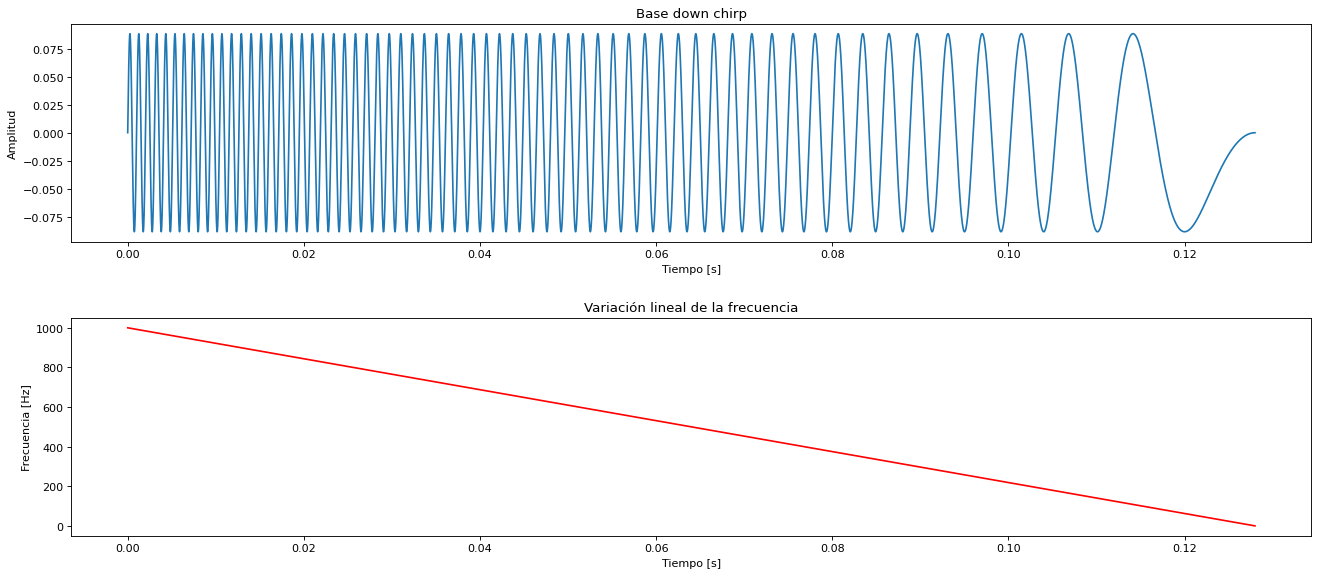

In [ ]:
#La base down chirp
base_down_chirp_t, base_down_chirp_f = base_down_chirp(SF, B, paso)


t=np.arange(0, num_muestras*paso/B, paso/B)
plt.figure(figsize=(20,8), dpi= 80, facecolor='w', edgecolor='k')
plt.subplot(2,1,1)
plt.plot(t,np.imag(base_down_chirp_t))
plt.title('Base down chirp')
plt.xlabel('Tiempo [s]')
plt.ylabel('Amplitud')
plt.subplot(2,1,2)
plt.plot(t,base_down_chirp_f, color = "red")
plt.title('Variación lineal de la frecuencia')
plt.xlabel('Tiempo [s]')
plt.ylabel('Frecuencia [Hz]')
plt.subplots_adjust(left=0.125,
                    bottom=0.1, 
                    right=0.9, 
                    top=0.9, 
                    wspace=0.2, 
                    hspace=0.35)
plt.show()

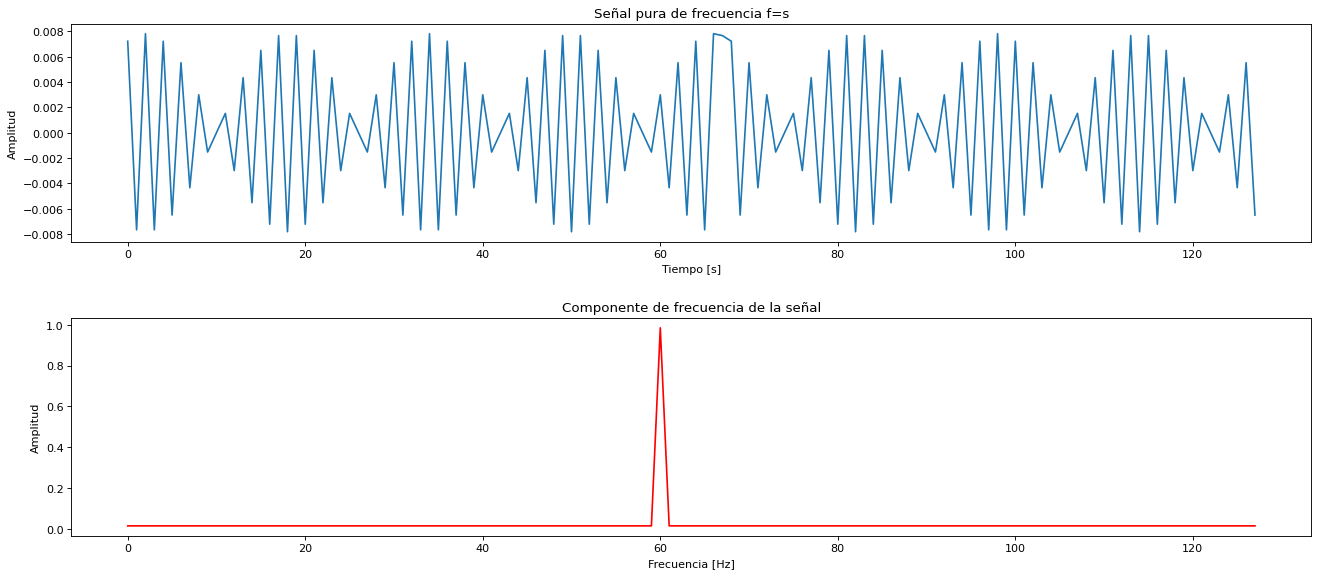

In [ ]:
lora_symbols_n = []
base_down_chirp_n = []

for i in range(len(lora_tiempo)):
  if(i%(1/paso)==0):#Solo tomo los valores enteros, con un total de 2^SF
    lora_symbols_n.append(lora_tiempo[i])
    base_down_chirp_n.append(base_down_chirp_t[i])

dechirping=[]
for i in range(len(lora_symbols_n)):
  dechirping.append(lora_symbols_n[i]*base_down_chirp_n[i])
t=np.arange(0,num_muestras*paso,1)
plt.figure(figsize=(20,8), dpi= 80, facecolor='w', edgecolor='k')
plt.subplot(2,1,1)
plt.plot(t,np.real(dechirping))
plt.title('Señal pura de frecuencia f=s')
plt.xlabel('Tiempo [s]')
plt.ylabel('Amplitud')
plt.subplot(2,1,2)
plt.plot(t,abs(np.fft.fft(dechirping)), color = "red")
plt.title('Componente de frecuencia de la señal')
plt.xlabel('Frecuencia [Hz]')
plt.ylabel('Amplitud')
plt.subplots_adjust(left=0.125,
                    bottom=0.1, 
                    right=0.9, 
                    top=0.9, 
                    wspace=0.2, 
                    hspace=0.35)
plt.show()

#Inmunidad a la Interferencia: LoRa vs FSK

##Modulación LoRa

Para evaluar la respuesta de las distintas modulaciones frente a un ruido generado en una banda de frecuencias (interferencia), debemos implementar una forma de generar este ruido, y filtrarlo de modo que solo exista interferencia en una banda.

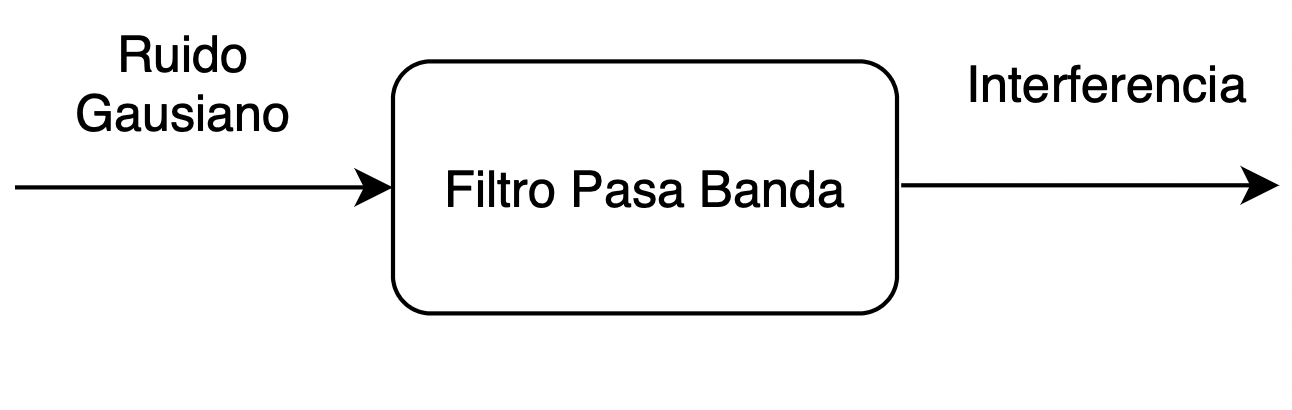

En el siguiente bloque de código, se implementarán las funciones correspondientes para generar un filtro pasa banda.

In [ ]:
#FUENTE DE ESCALADO DE RUIDO: https://dsp.stackexchange.com/questions/9654/how-to-generate-band-limited-gaussian-white-noise-in-matlab
#FUENTE DE FILTRADO DE RUIDO: https://stackoverflow.com/questions/12093594/how-to-implement-band-pass-butterworth-filter-with-scipy-signal-butter

from scipy.signal import butter, sosfilt, sosfreqz, welch

def butter_bandpass(lowcut, highcut, fs, order=5): # Genera un filtro pasa banda
  nyq = 0.5 * fs
  low = lowcut / nyq
  high = highcut / nyq
  sos = butter(order, [low, high], analog=False, btype='band', output='sos')
  w, h = sosfreqz(sos, fs=fs, worN=2000)
  plt.title('Respuesta en frecuencia del Filtro')
  plt.plot(w, abs(h))
  plt.xlabel('Frecuencia [Hz]')
  plt.ylabel('Ganancia')
  plt.show()
  return sos

def butter_bandpass_filter(data, lowcut, highcut, fs, order=5): # Filtra la señal pasada como parametro
  sos = butter_bandpass(lowcut, highcut, fs, order=order)
  y = sosfilt(sos, data)
  return y


Luego, debemos tener en cuenta el valor de SIR (Signal to Interference Ratio), para realizar el cálculo de la potencia que deberá tener nuestra interferencia. 
Esto se hace utilizando la fórmula de SIR:

$SIR = \frac{\frac{1}{N}\sum_{i=1}^{n}\left | S_{i} \right |^{2}}{\frac{1}{M}\sum_{i=1}^{M}\left | I_{i} \right |^{2}} = \frac{pot(S)}{pot(I)} = pot(S)[dB] - pot(I)[dB]$

Procedemos a definir las funciones para calcular la potencia de una señal:

In [ ]:
def potenciaDB(signal): # Devuelve la potencia en dB de la señal
  pot = 0
  signal_w = abs(np.array(signal))**2
  signal_avg = np.mean(signal_w)
  signal_db = 10 * np.log10(signal_avg)
  return signal_db

def dbInvert(db): # Realiza la operacion inversa
  return 10**(db/10)

Para generar el ruido en todo el espectro de frecuencias, se generan tantas muestras aleatorias como muestras de señales se tengan, con media 0, y con varianza igual al valor de veces calculado para el ruido. Esto resulta en un ruido blanco en todo el espectro de frecuencias. Luego se le aplica el filtro pasa banda, para limitarlo en el intervalo de frecuencias deseado.

Para cumplir con el SIR deseado, se debe aplicar un escalado de la interferencia, ya que luego de aplicar el filtro, la varianza del ruido es modificada. Se le debe aplicar un coeficiente, que se calcula como:

$coef = \frac{\sqrt{\sigma ^{2}_{ruido}}}{\sigma_{interf}} = \frac{\sigma_{ruido}}{\sigma_{interf}}$

Por ultimo, se multiplican todas las muestras de la interferencia con este coeficiente, y podemos ver que la SIR entre la señal y la interferencia, es la deseada.

In [ ]:
def interf_generator(signal, SIR, lowcut, highcut): # Genera una señal de interferencia con la potencia deseada, en el rango de frecuencias deseado.
  signal_db = potenciaDB(signal)
  ruido_db = signal_db - SIR
  ruido_times = dbInvert(ruido_db)
  ruido = np.random.normal(0, np.real(ruido_times)**2, len(signal))

  interferencia = butter_bandpass_filter(ruido, lowcut, highcut, B, order=9)

  coef = np.sqrt(np.real(ruido_times)) / np.std(interferencia)
  interferencia = coef * interferencia
  return ruido, interferencia

Realizamos la carga de parametros y la generación de la interferencia, donde podemos ver la respuesta en frecuencia de la misma.

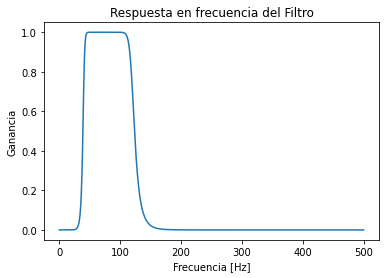

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: Data has no positive values, and therefore cannot be log-scaled.
  if __name__ == '__main__':


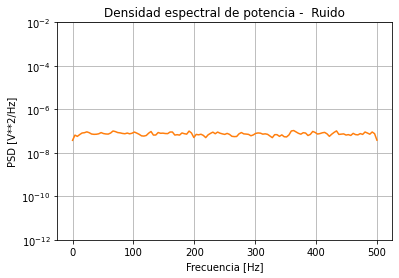

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:18: UserWarning: Data has no positive values, and therefore cannot be log-scaled.


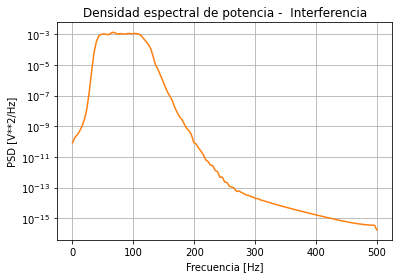

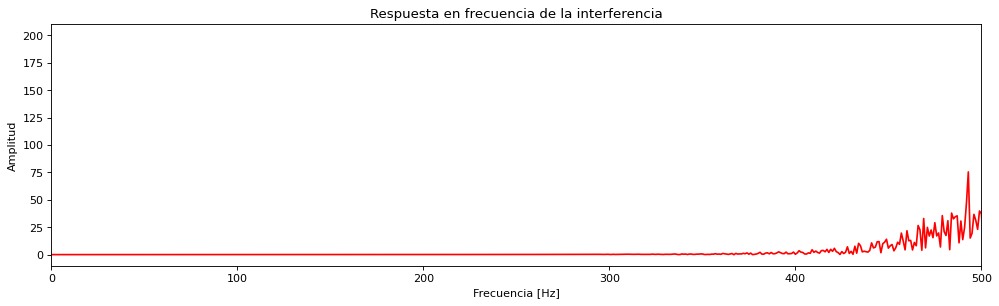





SIR REAL =  -10.000000010381276






In [ ]:
lowcut = 40
highcut = 120
SIR = -10

ruido, interferencia = interf_generator(lora_tiempo, SIR, lowcut, highcut)

(sym, frec) = plt.psd(ruido, Fs=B)

plt.semilogy(frec, sym)
plt.title("Densidad espectral de potencia -  Ruido")
plt.ylim([1e-12, 1e-2])
plt.xlabel('Frecuencia [Hz]')
plt.ylabel('PSD [V**2/Hz]')
plt.show()

(sym, frec) = plt.psd(interferencia, Fs=B)

plt.semilogy(frec, sym)
plt.title("Densidad espectral de potencia -  Interferencia")
plt.xlabel('Frecuencia [Hz]')
plt.ylabel('PSD [V**2/Hz]')
plt.show()


t=np.arange(0,num_muestras,1)
plt.figure(figsize=(15,4), dpi= 80, facecolor='w', edgecolor='k')
plt.plot(t, abs(np.fft.fft(interferencia)), color = 'r')
plt.title("Respuesta en frecuencia de la interferencia")
plt.xlim(0, 500)
plt.xlabel('Frecuencia [Hz]')
plt.ylabel('Amplitud')
plt.show()

print("\n\n\n")
print("SIR REAL = ", potenciaDB(lora_tiempo) - potenciaDB(interferencia))
print("\n\n\n")

Si observamos el gráfico DEP del ruido gausiano, podemos ver una típica distribucion de potencias perteneciente al ruido gausiano, debido a que presenta componentes en todas las frecuencias del espectro.
Si luego observamos el grafico DEP de la interferencia filtrada, observamos que efectivamente, en el rango de la banda filtrada la potencia se mantiene casi constante, y cae luego de la potencia de corte superior.

Luego podemos sumarle esta interferencia a nuestra onda LoRa, donde observamos como queda en función del tiempo:

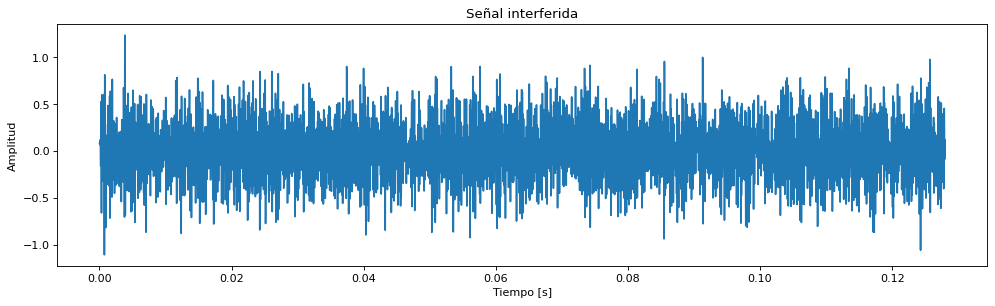

In [ ]:
lora_interferida = []

lora_interferida = lora_tiempo + interferencia

t=np.arange(0, num_muestras/B*paso, paso/B)
plt.figure(figsize=(15,4), dpi= 80, facecolor='w', edgecolor='k')
plt.plot(t,np.real(lora_interferida))
plt.title('Señal interferida')
plt.xlabel('Tiempo [s]')
plt.ylabel('Amplitud')

plt.show()

Por ultimo, podemos realizar la demodulación, utilizando el método explicado anteriormente, y observamos como queda nuestra señal demodulada:

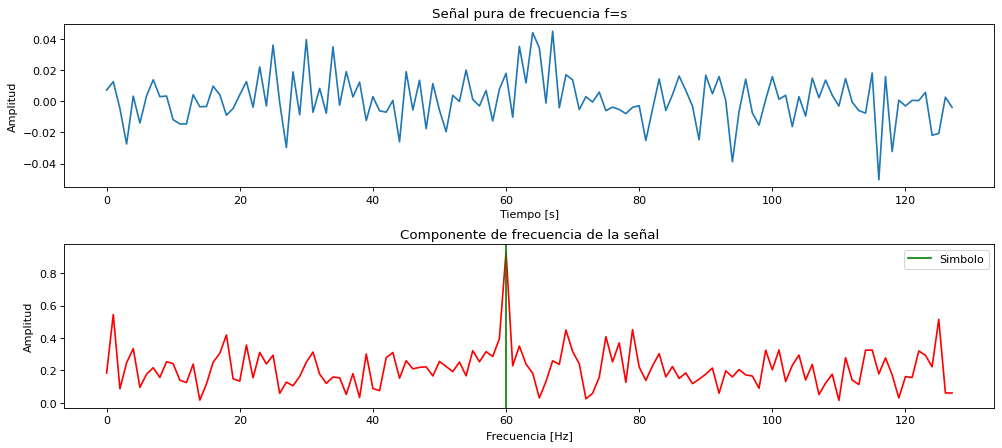

In [ ]:
lora_interferencia_symbols_n = []

for i in range(len(lora_interferida)):
  if(i%(1/paso)==0):#Solo tomo los valores enteros, con un total de 2^SF
    lora_interferencia_symbols_n.append(lora_interferida[i])

dechirping_interferido=[]
for i in range(len(lora_interferencia_symbols_n)):
  dechirping_interferido.append(lora_interferencia_symbols_n[i]*base_down_chirp_n[i])

t=np.arange(0,num_muestras*paso,1)
plt.figure(figsize=(15,6), dpi= 80, facecolor='w', edgecolor='k')
plt.subplot(2,1,1)
plt.plot(t,np.real(dechirping_interferido))
plt.title('Señal pura de frecuencia f=s')
plt.xlabel('Tiempo [s]')
plt.ylabel('Amplitud')
plt.subplot(2,1,2)
plt.plot(t,abs(np.fft.fft(dechirping_interferido)), color = "red")
plt.title('Componente de frecuencia de la señal')
plt.xlabel('Frecuencia [Hz]')
plt.ylabel('Amplitud')
plt.axvline(x=s, color = 'green', label = "Simbolo")
plt.legend()
plt.subplots_adjust(left=0.125,
                    bottom=0.1, 
                    right=0.9, 
                    top=0.9, 
                    wspace=0.2, 
                    hspace=0.35)
plt.show()

Podemos observar, que con una interferencia en un rango de 40Hz a 120Hz, con una SIR de -10dB, la modulación LoRa sigue siendo capaz de transmitir un simbolo correctamente (en este caso s = 60).

##Modulación FSK

Para implementar la modulación FSK a fines de comparar su respuesta a la interferencia con LoRa, simplemente realizamos una transmision de un '0' y un '1', utilizando una frecuencia de portadora de 50Hz. Cuando se transmite un '0', la frecuencia de la onda es de 50Hz, y cuando se transmite un '1', la frecuencia es de 100Hz. Por lo que podemos observar, la respuesta en frecuencia de la onda es en 50Hz y 100Hz.

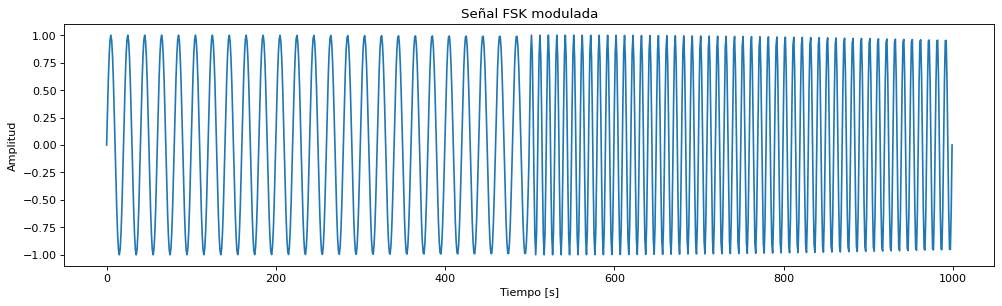

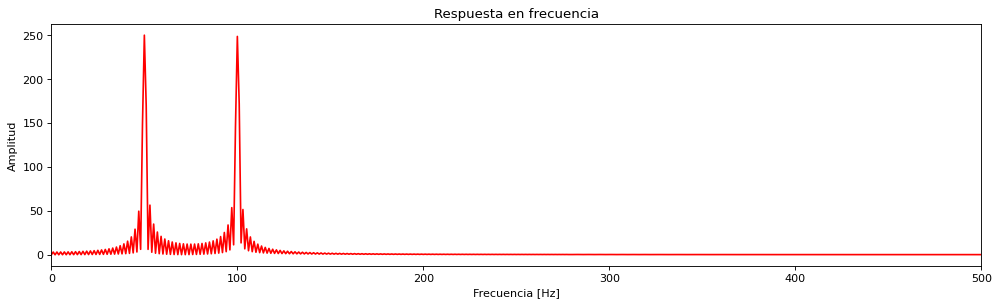

In [ ]:
#FUENTE: https://notebook.community/calebmadrigal/radio-hacking-scripts/fsk_modem_research
samp_rate = B  # samples/second
frecuencia_portadora = 50  # Hz
t = np.linspace(0, 1, samp_rate)
portadora = np.sin(frecuencia_portadora * 2 * np.pi * t)

mark_multiplier_array = 2*np.cos(frecuencia_portadora * 2 * np.pi * t) # Genero una onda 2 * cos(x) para duplicar la frecuencia de la portadora
modulation_array = np.array([1]*500 + [i for i in mark_multiplier_array[500:]]) # La primer mitad del arreglo es un 1 y la otra mitad contiene la onda 2*cos(x)

modulada = portadora * modulation_array # multiplico la portadora por el arreglo

plt.figure(figsize=(15,4), dpi= 80, facecolor='w', edgecolor='k')
plt.title('Señal FSK modulada')
plt.plot(modulada)
plt.xlabel('Tiempo [s]')
plt.ylabel('Amplitud')
plt.show()

plt.figure(figsize=(15,4), dpi= 80, facecolor='w', edgecolor='k')
plt.title('Respuesta en frecuencia')
plt.xlim(0, 500)
plt.plot(abs(np.fft.fft(modulada)), color = 'red')
plt.xlabel('Frecuencia [Hz]')
plt.ylabel('Amplitud')
plt.show()


Procedemos a generar una interferencia, de modo que la SIR entre la señal FSK y el ruido fitrado, sera igual que la SIR de LoRa, con el fin de realizar una comparacion justa.

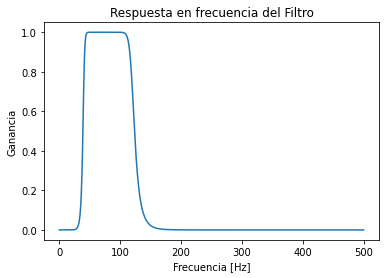



SIR REAL =  -10.0000146283338





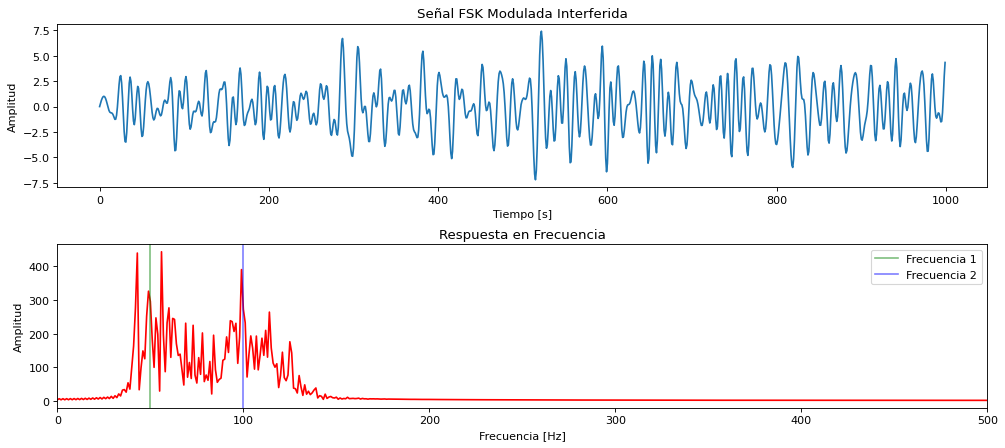

In [ ]:
ruido, interferencia = interf_generator(modulada, SIR, lowcut, highcut)

print("\n\nSIR REAL = ", potenciaDB(modulada) - potenciaDB(interferencia))
print("\n\n")
modulada = modulada + interferencia

plt.figure(figsize=(15,6), dpi= 80, facecolor='w', edgecolor='k')
plt.subplot(2,1,1)
plt.title('Señal FSK Modulada Interferida')
plt.plot(modulada)
plt.xlabel('Tiempo [s]')
plt.ylabel('Amplitud')

plt.subplot(2,1,2)
plt.title('Respuesta en Frecuencia')
plt.xlim(0, 500)
plt.plot(abs(np.fft.fft(modulada)), color = 'red')
plt.xlabel('Frecuencia [Hz]')
plt.ylabel('Amplitud')
plt.axvline(x=frecuencia_portadora, color = 'green', label = "Frecuencia 1", alpha = 0.5)
plt.axvline(x=frecuencia_portadora * 2, color = 'blue', label = "Frecuencia 2", alpha = 0.5)
plt.legend()
plt.subplots_adjust(left=0.125,
                    bottom=0.1, 
                    right=0.9, 
                    top=0.9, 
                    wspace=0.2, 
                    hspace=0.35)
plt.show()

Podemos observar, que a diferencia de LoRa, la modulación FSK pierde sus datos debido a la interferencia que recibe. Esto sucede porque LoRa tiene un espectro de frecuencias mucho mayor que FSK, como se muestra en el siguiente grafico.

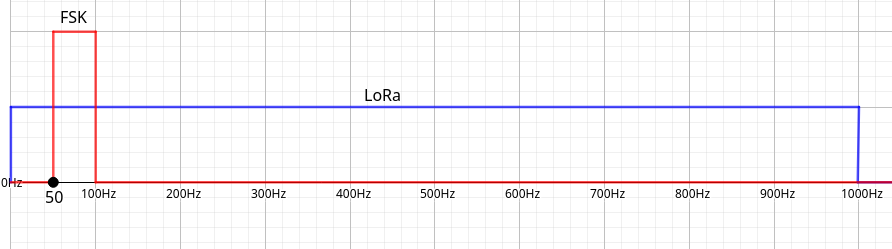

Si ahora graficamos tambien el intervalo de la interferencia, observamos que el espectro de frecuencias de FSK queda totalmente interferido. Mientras que en el caso de LoRa, solo una pequeña parte de su espectro es interferido.

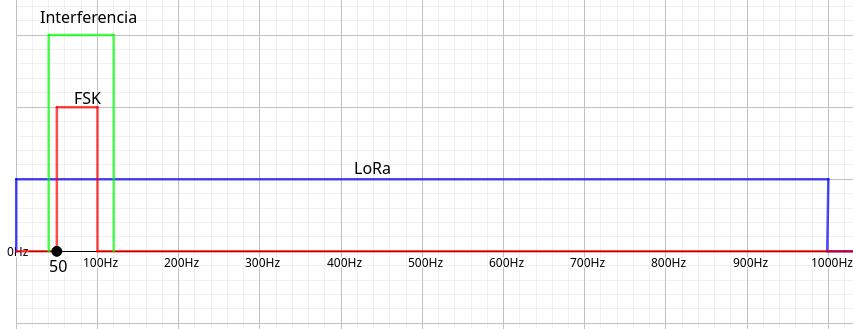

#Referencias:
- "Frequency Shift Chirp Modulation: The LoRa Modulation", escrito por Lorenzo Evangelista
- "How LoRa Modulation really works", de 'Visual Electric'
  - https://www.youtube.com/watch?v=jHWepP1ZWTk&t=1148s&ab_channel=VisualElectric

- Filtrado de ruido:
  - https://stackoverflow.com/questions/12093594/how-to-implement-band-pass-butterworth-filter-with-scipy-signal-butter

- Modulación FSK:
  - https://notebook.community/calebmadrigal/radio-hacking-scripts/fsk_modem_research


[![CC BY 4.0][cc-by-shield]][cc-by]

This work is licensed under a
[Creative Commons Attribution 4.0 International License][cc-by].

[![CC BY 4.0][cc-by-image]][cc-by]

[cc-by]: http://creativecommons.org/licenses/by/4.0/
[cc-by-image]: https://i.creativecommons.org/l/by/4.0/88x31.png
[cc-by-shield]: https://img.shields.io/badge/License-CC%20BY%204.0-lightgrey.svg

![logo_neon_erasmus](https://raw.githubusercontent.com/neon-iot/communication_labs/main/detection_theory/notebooks/images/BannerSupportErasmus_.png)
